In [1]:
import tensorflow as tf
import numpy as np
import cv2
import time
from matplotlib import pyplot as plt
from itertools import product
from math import sqrt


In [2]:
class FeaturePyramidNeck(tf.keras.layers.Layer):
    """
        Creating the backbone component of feature Pyramid Network
        Arguments:
            num_fpn_filters
    """

    def __init__(self, num_fpn_filters):
        super(FeaturePyramidNeck, self).__init__()
        self.upSample = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')

        # no Relu for downsample layer
        self.downSample1 = tf.keras.layers.Conv2D(num_fpn_filters, (3, 3), 2, padding="same",
                                                  kernel_initializer=tf.keras.initializers.glorot_uniform())

        self.downSample2 = tf.keras.layers.Conv2D(num_fpn_filters, (3, 3), 2, padding="same",
                                                  kernel_initializer=tf.keras.initializers.glorot_uniform())

        self.lateralCov1 = tf.keras.layers.Conv2D(num_fpn_filters, (1, 1), 1, padding="same",
                                                  kernel_initializer=tf.keras.initializers.glorot_uniform())
        self.lateralCov2 = tf.keras.layers.Conv2D(num_fpn_filters, (1, 1), 1, padding="same",
                                                  kernel_initializer=tf.keras.initializers.glorot_uniform())
        self.lateralCov3 = tf.keras.layers.Conv2D(num_fpn_filters, (1, 1), 1, padding="same",
                                                  kernel_initializer=tf.keras.initializers.glorot_uniform())

        # predict layer for FPN
        self.predictP5 = tf.keras.layers.Conv2D(num_fpn_filters, (3, 3), 1, padding="same",
                                                kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                                activation="relu")
        self.predictP4 = tf.keras.layers.Conv2D(num_fpn_filters, (3, 3), 1, padding="same",
                                                kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                                activation="relu")
        self.predictP3 = tf.keras.layers.Conv2D(num_fpn_filters, (3, 3), 1, padding="same",
                                                kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                                activation="relu")

    def call(self, c3, c4, c5):
        # lateral conv for c3 c4 c5
        p5 = self.lateralCov1(c5)
        p4 = self._crop_and_add(self.upSample(p5), self.lateralCov2(c4))
        p3 = self._crop_and_add(self.upSample(p4), self.lateralCov3(c3))
        print("p3: ", p3.shape)

        # smooth pred layer for p3, p4, p5
        p3 = self.predictP3(p3)
        p4 = self.predictP4(p4)
        p5 = self.predictP5(p5)

        # downsample conv to get p6, p7
        p6 = self.downSample1(p5)
        p7 = self.downSample2(p6)

        return [p3, p4, p5, p6, p7]

    def _crop_and_add(self, x1, x2):
        """
        for p4, c4; p3, c3 to concatenate with matched shape
        https://tf-unet.readthedocs.io/en/latest/_modules/tf_unet/layers.html
        """
        x1_shape = x1.shape
        x2_shape = x2.shape
        offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
        size = [-1, x2_shape[1], x2_shape[2], -1]
        x1_crop = tf.slice(x1, offsets, size)
        return tf.add(x1_crop, x2)

In [125]:
out = ['conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
base_model = tf.keras.applications.ResNet50(input_shape=(360, 1205, 3), #input_shape=(360, 1205, 3),
                                                    include_top=False,
                                                    layers=tf.keras.layers,
                                                    weights='imagenet')
backbone_resnet = tf.keras.Model(inputs=base_model.input,
                                              outputs=[base_model.get_layer(x).output for x in out])

backbone_fpn = FeaturePyramidNeck(256)

In [126]:
backbone_resnet.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 360, 1205, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 366, 1211, 3) 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 180, 603, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 180, 603, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [127]:
feature_map_size = np.array([list(base_model.get_layer(x).output.shape[1:3]) for x in out])

In [128]:
out_height_p6 = np.ceil((feature_map_size[-1, 0]).astype(np.float32) / float(2))
out_width_p6  = np.ceil((feature_map_size[-1, 1]).astype(np.float32) / float(2))

In [129]:
out_height_p7 = np.ceil(out_height_p6 / float(2))
out_width_p7  = np.ceil(out_width_p6/ float(2))

In [130]:
feature_map_size = np.concatenate((feature_map_size, [[out_height_p6, out_width_p6], [out_height_p7, out_width_p7]]), axis=0)

In [131]:
feature_map_size

array([[ 45., 151.],
       [ 23.,  76.],
       [ 12.,  38.],
       [  6.,  19.],
       [  3.,  10.]])

In [132]:
aspect_ratio=[1, 0.5, 2]
scale=[24, 48, 96, 192, 384]
img_h = 360
img_w = 1205

prior_boxes = []
num_anchors = []
for idx, f_size in enumerate(feature_map_size):
    # print("Create priors for f_size:%s", f_size)
    count_anchor = 0
    for j, i in product(range(int(f_size[0])), range(int(f_size[1]))):
        f_k_h = img_h / (f_size[0] + 1)
        f_k_w = img_w / (f_size[1] + 1)
        x = f_k_w * (i + 1)
        y = f_k_h * (j + 1)
        for ars in aspect_ratio:
            a = sqrt(ars)
            w = scale[idx] * a
            h = scale[idx] / a
            prior_boxes += [x - (w / 2), y - (h / 2), x + (w / 2), y + (h / 2)]
            count_anchor += 1
    num_anchors.append(count_anchor)


In [134]:
num_anchors

[20385, 5244, 1368, 342, 90]

In [22]:
class TfExampleDecoder(object):
    def __init__(self):
        self._keys_to_features = {
            'image/height': tf.io.FixedLenFeature([], dtype=tf.int64),
            'image/width': tf.io.FixedLenFeature([], dtype=tf.int64),
            'image/encoded': tf.io.FixedLenFeature([], dtype=tf.string),
            'image/object/bbox/xmin': tf.io.VarLenFeature(dtype=tf.float32),
            'image/object/bbox/xmax': tf.io.VarLenFeature(dtype=tf.float32),
            'image/object/bbox/ymin': tf.io.VarLenFeature(dtype=tf.float32),
            'image/object/bbox/ymax': tf.io.VarLenFeature(dtype=tf.float32),
            'image/object/class/label': tf.io.VarLenFeature(dtype=tf.int64),
            'image/object/is_crowd': tf.io.VarLenFeature(dtype=tf.int64),
            'image/object/mask': tf.io.VarLenFeature(dtype=tf.string),
        }

    def _decode_image(self, parsed_tensors):
        image = tf.io.decode_jpeg(parsed_tensors['image/encoded'])
        image.set_shape([None, None, 3])
        return image

    def _decode_boxes(self, parsed_tensors):
        # denormalize the box here
        xmin = parsed_tensors['image/object/bbox/xmin']
        ymin = parsed_tensors['image/object/bbox/ymin']
        xmax = parsed_tensors['image/object/bbox/xmax']
        ymax = parsed_tensors['image/object/bbox/ymax']
        return tf.stack([ymin, xmin, ymax, xmax], axis=-1)

    def _decode_masks(self, parsed_tensors):
        def _decode_png_mask(png_bytes):
            mask = tf.squeeze(
                tf.io.decode_png(png_bytes, channels=1, dtype=tf.uint8), axis=-1)
            mask = tf.cast(mask, dtype=tf.float32)
            mask.set_shape([None, None])
            return mask

        height = parsed_tensors['image/height']
        width = parsed_tensors['image/width']
        masks = parsed_tensors['image/object/mask']
        return tf.cond(
            pred=tf.greater(tf.size(input=masks), 0),
            true_fn=lambda: tf.map_fn(_decode_png_mask, masks, dtype=tf.float32),
            false_fn=lambda: tf.zeros([0, height, width], dtype=tf.float32))

    def decode(self, serialized_example):
        parsed_tensors = tf.io.parse_single_example(
            serialized=serialized_example, features=self._keys_to_features
        )

        for k in parsed_tensors:
            if isinstance(parsed_tensors[k], tf.SparseTensor):
                if parsed_tensors[k].dtype == tf.string:
                    parsed_tensors[k] = tf.sparse.to_dense(
                        parsed_tensors[k], default_value=""
                    )
                else:
                    parsed_tensors[k] = tf.sparse.to_dense(
                        parsed_tensors[k], default_value=0)

        image = self._decode_image(parsed_tensors)
        boxes = self._decode_boxes(parsed_tensors)
        masks = self._decode_masks(parsed_tensors)
        is_crowds = tf.cond(
            tf.greater(tf.shape(parsed_tensors['image/object/is_crowd']), 0),
            lambda: tf.cast(parsed_tensors['image/object/is_crowd'], dtype=tf.bool),
            lambda: tf.zeros_like(parsed_tensors['image/object/class/label'], dtype=tf.bool))

        decoded_tensors = {
            'image': image,
            'height': parsed_tensors['image/height'],
            'width': parsed_tensors['image/width'],
            'gt_classes': parsed_tensors['image/object/class/label'],
            'gt_is_crowd': is_crowds,
            'gt_bboxes': boxes,
            'gt_masks': masks
        }

        return decoded_tensors

In [23]:
_example_decoder = TfExampleDecoder()
trRawDataset = tf.data.TFRecordDataset("/home/deploy/ved/data/train.record")
dsTrain = trRawDataset.map(_example_decoder.decode)

In [24]:
dsTrain

<MapDataset shapes: {image: (None, None, 3), height: (), width: (), gt_classes: (None,), gt_is_crowd: (None,), gt_bboxes: (None, 4), gt_masks: (None, None, None)}, types: {image: tf.uint8, height: tf.int64, width: tf.int64, gt_classes: tf.int64, gt_is_crowd: tf.bool, gt_bboxes: tf.float32, gt_masks: tf.float32}>

In [61]:
for parsed_record in dsTrain.take(3):
    img_test = parsed_record['image'].numpy()

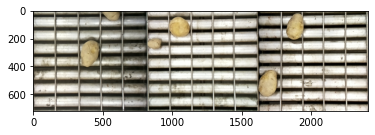

In [62]:
from matplotlib import pyplot as plt
plt.imshow(img_test)

In [3]:
from itertools import product
from math import sqrt

def make_priors(img_size_h, img_size_w, feature_map_size, aspect_ratio, scale):
    """
    Create anchor boxes for each feature maps in [x, y, w, h], (x, y) is the center of anchor
    :param feature_map_size:
    :param img_size:
    :param aspect_ratio:
    :param scale:
    :return:
    """
    prior_boxes = []
    num_anchors = 0
    for idx, f_size in enumerate(feature_map_size):
        # print("Create priors for f_size:%s", f_size)
        count_anchor = 0
        for j, i in product(range(int(f_size[0])), range(int(f_size[1]))):
            # i,j are pixels values in feature map
            # + 0.5 because priors are in center
            x = (i + 0.5) / f_size[1] # normalize the pixel values
            y = (j + 0.5) / f_size[0]
            for ars in aspect_ratio:
                a = sqrt(ars)
                w = scale[idx] * a / img_size_w # normalize the width value
                h = scale[idx] / a / img_size_h
                # directly use point form here => [cx, cy, w, h]
                prior_boxes += [x, y, w, h]
            count_anchor += 1
        num_anchors += count_anchor
    output = tf.reshape(tf.convert_to_tensor(prior_boxes), [-1, 4])
    output = tf.cast(output, tf.float32)
    return num_anchors, output

In [4]:
class Yolact(tf.keras.Model):
    """
        Creating the YOLCAT Architecture
        Arguments:

    """

    def __init__(self, img_h, img_w, fpn_channels, num_class, num_mask, aspect_ratio, scales):
        super(Yolact, self).__init__()
        out = ['conv3_block4_out', 'conv4_block6_out', 'conv5_block3_out']
        # use pre-trained ResNet50
        # Todo figure out how pre-trained can be train again
        base_model = tf.keras.applications.ResNet50(input_shape=(img_h, img_w, 3),
                                                    include_top=False,
                                                    layers=tf.keras.layers,
                                                    weights='imagenet')
        # extract certain feature maps for FPN
        self.backbone_resnet = tf.keras.Model(inputs=base_model.input,
                                              outputs=[base_model.get_layer(x).output for x in out])
        
        # Calculating feature map size
        # https://stackoverflow.com/a/44242277/4582711
        # https://github.com/tensorflow/tensorflow/issues/4297#issuecomment-246080982
        self.feature_map_size = np.array([list(base_model.get_layer(x).output.shape[1:3]) for x in out])
        out_height_p6 = np.ceil((self.feature_map_size[-1, 0]).astype(np.float32) / float(2))
        out_width_p6  = np.ceil((self.feature_map_size[-1, 1]).astype(np.float32) / float(2))
        out_height_p7 = np.ceil(out_height_p6 / float(2))
        out_width_p7  = np.ceil(out_width_p6/ float(2))
        self.feature_map_size = np.concatenate((self.feature_map_size, [[out_height_p6, out_width_p6], [out_height_p7, out_width_p7]]), axis=0)
        self.protonet_out_size = self.feature_map_size[0]*2 # Only one upsampling on p3 

        self.backbone_fpn = FeaturePyramidNeck(fpn_channels)
        self.protonet = ProtoNet(num_mask)

        # semantic segmentation branch to boost feature richness
        self.semantic_segmentation = tf.keras.layers.Conv2D(num_class, (1, 1), 1, padding="same",
                                                            kernel_initializer=tf.keras.initializers.glorot_uniform())

        self.num_anchor, self.priors = make_priors(img_h, img_w, self.feature_map_size, aspect_ratio, scales)
#         print("prior shape:", self.priors.shape)
#         print("num anchor per feature map: ", self.num_anchor)

        # shared prediction head
        self.predictionHead = PredictionModule(256, len(aspect_ratio), num_class, num_mask)

    def set_bn(self, mode='train'):
        if mode == 'train':
            for layer in self.backbone_resnet.layers:
                if isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = False
        else:
            for layer in self.backbone_resnet.layers:
                if isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = True


    @tf.function(input_signature=[tf.TensorSpec([None, None, None, 3], tf.uint8)])
    def __call__(self, inputs):
        # backbone(ResNet + FPN)
        # tf.print("inputs max: ", tf.reduce_max(tf.reshape(inputs[0], [-1])))
        c3, c4, c5 = self.backbone_resnet(inputs)
        # tf.print("c3 max: ", tf.reduce_max(tf.reshape(c3, [-1])))
        # print("c3: ", c3.shape)
        # print("c4: ", c4.shape)
        # print("c5: ", c5.shape)
        fpn_out = self.backbone_fpn(c3, c4, c5)

        # Protonet branch
        p3 = fpn_out[0]
        protonet_out = self.protonet(p3)
        # print("protonet: ", protonet_out.shape)

        # semantic segmentation branch
        seg = self.semantic_segmentation(p3)

        
        # Prediction Head branch
#         pred_cls_p3, pred_offset_p3, pred_coef_p3 = self.predictionHead(fpn_out[0])
#         pred_cls_p4, pred_offset_p4, pred_coef_p4 = self.predictionHead(fpn_out[1])
#         pred_cls_p5, pred_offset_p5, pred_coef_p5 = self.predictionHead(fpn_out[2])
#         pred_cls_p6, pred_offset_p6, pred_coef_p6 = self.predictionHead(fpn_out[3])
#         pred_cls_p7, pred_offset_p7, pred_coef_p7 = self.predictionHead(fpn_out[4])
        
        pred_cls = []
        pred_offset = []
        pred_mask_coef = []

        # all output from FPN use same prediction head
        for f_map in fpn_out:
            cls, offset, coef = self.predictionHead(f_map)
            pred_cls.append(cls)
            pred_offset.append(offset)
            pred_mask_coef.append(coef)
        
        pred_cls = tf.concat(pred_cls, axis=1)
        pred_offset = tf.concat(pred_offset, axis=1)
        pred_mask_coef = tf.concat(pred_mask_coef, axis=1)
            
#         pred_cls = tf.concat([pred_cls_p3, pred_cls_p4, pred_cls_p5, pred_cls_p6, pred_cls_p7], axis=1)
#         pred_offset = tf.concat([pred_offset_p3, pred_offset_p4, pred_offset_p5, pred_offset_p6, pred_offset_p7], axis=1)
#         pred_mask_coef = tf.concat([pred_coef_p3, pred_coef_p4, pred_coef_p5, pred_coef_p6, pred_coef_p7], axis=1)

        pred = {
            'pred_cls': pred_cls,
            'pred_offset': pred_offset,
            'pred_mask_coef': pred_mask_coef,
            'proto_out': protonet_out,
            'seg': seg,
            'priors': self.priors
        }

        return pred

In [5]:
class PredictionModule(tf.keras.layers.Layer):

    def __init__(self, out_channels, num_anchors, num_class, num_mask):
        super(PredictionModule, self).__init__()
        self.num_anchors = num_anchors
        self.num_class = num_class
        self.num_mask = num_mask

        self.Conv = tf.keras.layers.Conv2D(out_channels, (3, 3), 1, padding="same",
                                           kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                           activation="relu")

        self.classConv = tf.keras.layers.Conv2D(self.num_class * self.num_anchors, (3, 3), 1, padding="same",
                                                kernel_initializer=tf.keras.initializers.glorot_uniform())

        self.boxConv = tf.keras.layers.Conv2D(4 * self.num_anchors, (3, 3), 1, padding="same",
                                              kernel_initializer=tf.keras.initializers.glorot_uniform())

        # activation of mask coef is tanh
        self.maskConv = tf.keras.layers.Conv2D(self.num_mask * self.num_anchors, (3, 3), 1, padding="same",
                                               kernel_initializer=tf.keras.initializers.glorot_uniform())

    def call(self, p):
        p = self.Conv(p)

        pred_class = self.classConv(p)
        pred_box = self.boxConv(p)
        pred_mask = self.maskConv(p)

        # reshape the prediction head result for following loss calculation
        pred_class = tf.reshape(pred_class, [tf.shape(pred_class)[0], -1, self.num_class])
        pred_box = tf.reshape(pred_box, [tf.shape(pred_box)[0], -1, 4])
        pred_mask = tf.reshape(pred_mask, [tf.shape(pred_mask)[0], -1, self.num_mask])

        # add activation for conf and mask coef
        pred_mask = tf.keras.activations.tanh(pred_mask)

        return pred_class, pred_box, pred_mask

In [6]:
class ProtoNet(tf.keras.layers.Layer):
    """
        Creating the component of ProtoNet
        Arguments:
            num_prototype
    """

    def __init__(self, num_prototype):
        super(ProtoNet, self).__init__()
        self.Conv1 = tf.keras.layers.Conv2D(256, (3, 3), 1, padding="same",
                                            kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                            activation="relu")
        self.Conv2 = tf.keras.layers.Conv2D(256, (3, 3), 1, padding="same",
                                            kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                            activation="relu")
        self.Conv3 = tf.keras.layers.Conv2D(256, (3, 3), 1, padding="same",
                                            kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                            activation="relu")
        self.upSampling = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.Conv4 = tf.keras.layers.Conv2D(256, (3, 3), 1, padding="same",
                                            kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                            activation="relu")

        self.finalConv = tf.keras.layers.Conv2D(num_prototype, (3, 3), 1, padding="same",
                                                kernel_initializer=tf.keras.initializers.glorot_uniform(),
                                                activation='relu')

    def call(self, p3):
        # (3,3) convolution * 3
        proto = self.Conv1(p3)
        proto = self.Conv2(proto)
        proto = self.Conv3(proto)

        # upsampling + convolution
        proto = self.upSampling(proto)
        proto = self.Conv4(proto)

        # final convolution
        proto = self.finalConv(proto)
        return proto

In [7]:
model = Yolact(img_h=360, 
              img_w=1205,
              fpn_channels=256,
              num_class=82,
              num_mask=32,
              aspect_ratio=[1.81, 0.86, 0.78],
              scales=[24, 48, 96, 130, 192])

In [9]:
def add_weight_decay(model, weight_decay):
	if (weight_decay is None) or (weight_decay == 0.0):
		return

	# recursion inside the model
	def add_decay_loss(m, factor):
		if isinstance(m, tf.keras.Model):
			for layer in m.layers:
				add_decay_loss(layer, factor)
		else:
			for param in m.trainable_weights:
				with tf.keras.backend.name_scope('weight_regularizer'):
					regularizer = lambda: tf.keras.regularizers.l2(factor)(param)
					m.add_loss(regularizer)

	# weight decay and l2 regularization differs by a factor of 2
	add_decay_loss(model, weight_decay/2.0)
	return


In [ ]:
# TODO: try this
# https://stackoverflow.com/a/61529570/4582711
l2 = tf.keras.regularizers.l2(1e-4)
for layer in model.layers:
    # if hasattr(layer, 'kernel'):
    # or
    # If you want to apply just on Conv
    if isinstance(layer, tf.keras.layers.Conv2D):
        model.add_loss(lambda layer=layer: l2(layer.kernel))

In [ ]:
# TODO: try this
# https://github.com/tensorflow/tensorflow/issues/33635#issuecomment-545390083
model = tf.keras.applications.ResNet50()
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        setattr(layer, 'kernel_regularizer', tf.keras.regularizers.l2(l=1e-5))
        
for layer in model.layers:
    if hasattr(layer, 'kernel_regularizer'):
        assert getattr(layer, 'kernel_regularizer').l2 == np.array([1e-5], dtype='float32')
        
assert model.losses == []
model.save_weights('resnet50.h5', save_format='h5')

new_model = tf.keras.models.model_from_json(model.to_json())
# new_model would have random weights
new_model.load_weights('resnet50.h5')
assert new_model.losses != [] #works fine

In [10]:
add_weight_decay(model, 5 * 1e-4)

In [11]:
call_output = model.__call__.get_concrete_function(tf.TensorSpec([None, None, None, 3], tf.uint8))

p3:  (None, 45, 151, 256)
p3:  (None, 45, 151, 256)


In [12]:
tf.saved_model.save(model, './saved_model', signatures={'serving_default': call_output})

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./saved_model/assets


In [4]:
# loaded = tf.saved_model.load('./saved_model')
loaded = tf.saved_model.load('/home/deploy/ved/YOLACT/saved_models/saved_model_4.0358458')

In [5]:
print(list(loaded.signatures.keys()))  # ["serving_default"]

['serving_default']


In [6]:
loaded.signatures['serving_default'].structured_outputs

{'pred_cls': TensorSpec(shape=(None, None, 2), dtype=tf.float32, name='pred_cls'),
 'pred_mask_coef': TensorSpec(shape=(None, None, 32), dtype=tf.float32, name='pred_mask_coef'),
 'pred_offset': TensorSpec(shape=(None, None, 4), dtype=tf.float32, name='pred_offset'),
 'priors': TensorSpec(shape=(27429, 4), dtype=tf.float64, name='priors'),
 'proto_out': TensorSpec(shape=(None, 90, 302, 32), dtype=tf.float32, name='proto_out'),
 'seg': TensorSpec(shape=(None, 45, 151, 2), dtype=tf.float32, name='seg')}

# Inferencing

In [9]:
img = cv2.imread('test.jpg')
img = cv2.resize(img, (1205, 360))
print(img.shape)
img = img.astype(np.float32, copy=False)
infer = loaded.signatures['serving_default']

@tf.function
def forward(x):
    return infer(x)

(360, 1205, 3)


In [63]:
img = cv2.resize(img_test, (1205, 360))
img = img.astype(np.float32, copy=False)

In [64]:
net_outs = forward(img[None, ...])

In [65]:
net_outs.keys()

dict_keys(['pred_cls', 'pred_offset', 'pred_mask_coef', 'seg', 'priors', 'proto_out'])

In [11]:
def _decode(box_p, priors, include_variances=False):
    # https://github.com/feiyuhuahuo/Yolact_minimal/blob/9299a0cf346e455d672fadd796ac748871ba85e4/utils/box_utils.py#L151
    """
    Decode predicted bbox coordinates using the scheme
    employed at https://lilianweng.github.io/lil-log/2017/12/31/object-recognition-for-dummies-part-3.html
        b_x = prior_w*loc_x + prior_x
        b_y = prior_h*loc_y + prior_y
        b_w = prior_w * exp(loc_w)
        b_h = prior_h * exp(loc_h)
    
    Note that loc is inputed as [c_x, x_y, w, h]
    while priors are inputed as [c_x, c_y, w, h] where each coordinate
    is relative to size of the image.
    
    Also note that prior_x and prior_y are center coordinates.
    """
    variances = [0.1, 0.2]
    box_p = tf.cast(box_p, tf.float32)
    priors = tf.cast(priors, tf.float32)
    if include_variances:
        b_x_y = priors[:, :2] + box_p[:, :2] * priors[:, 2:]* variances[0]
        b_w_h = priors[:, 2:] * tf.math.exp(box_p[:, 2:]* variances[1])
    else:
        b_x_y = priors[:, :2] + box_p[:, :2] * priors[:, 2:]
        b_w_h = priors[:, 2:] * tf.math.exp(box_p[:, 2:])
    
    boxes = tf.concat([b_x_y, b_w_h], axis=1)
    
    # [x_min, y_min, x_max, y_max]
    boxes = tf.concat([boxes[:, :2] - boxes[:, 2:] / 2, boxes[:, 2:] / 2 + boxes[:, :2]], axis=1)
    
    # [y_min, x_min, y_max, x_max]
    return tf.transpose(tf.stack([boxes[:, 1], boxes[:, 0],boxes[:, 3], boxes[:, 2]]))

In [80]:
def _traditional_nms(boxes, masks, scores, iou_threshold=0.5, conf_thresh=0.05, score_threshold=0.3, max_class_output_size=100, max_output_size=300, soft_nms_sigma=0.5):
    num_classes = scores.shape[0]

    box_lst = []
    mask_lst = []
    cls_lst = []
    scr_lst = []

    for _cls in range(num_classes):
        cls_scores = scores[_cls, :]
        selected_indices, selected_scores = tf.image.non_max_suppression_with_scores(
            boxes, 
            cls_scores, 
            max_output_size=max_class_output_size, 
            iou_threshold=iou_threshold, 
            score_threshold=score_threshold,
            soft_nms_sigma=soft_nms_sigma)
        
        box_lst.append(tf.squeeze(tf.gather(boxes, selected_indices)))
        mask_lst.append(tf.squeeze(tf.gather(masks, selected_indices)))
        cls_lst.append(selected_indices * 0 + _cls)
        scr_lst.append(tf.squeeze(tf.gather(cls_scores, selected_indices)))

    boxes = tf.concat(box_lst, axis=0)
    masks = tf.concat(mask_lst, axis=0)
    classes = tf.concat(cls_lst, axis=0)
    scores = tf.concat(scr_lst, axis=0)

    _ids = tf.argsort(scores)
    scores = tf.gather(scores, _ids)[:max_output_size]
    boxes = tf.gather(boxes, _ids)[:max_output_size]
    masks = tf.gather(masks, _ids)[:max_output_size]
    classes = tf.gather(classes, _ids)[:max_output_size]

    return boxes, masks, classes, scores

In [81]:
def _sanitize_coordinates(_x1, _x2, img_size: int, padding: int = 0):
    """
    Sanitizes the input coordinates so that x1 < x2, x1 != x2, x1 >= 0, and x2 <= image_size.
    Also converts from relative to absolute coordinates and casts the results to long tensors.
    Warning: this does things in-place behind the scenes so copy if necessary.
    """
    x1 = tf.math.minimum(_x1, _x2)
    x2 = tf.math.maximum(_x1, _x2)
    x1 = tf.clip_by_value(x1 - padding, clip_value_min=0, clip_value_max=img_size)
    x2 = tf.clip_by_value(x2 + padding, clip_value_min=0, clip_value_max=img_size)

    # Normalize the coordinates
    return x1/img_size, x2/img_size

In [82]:
def _crop_and_normalize(masks, boxes, padding: int = 1, crop_size=(30,30)):
    """
    "Crop" predicted masks by zeroing out everything not in the predicted bbox.
    Args:
        - masks should be a size [h, w, n] tensor of masks
        - boxes should be a size [n, 4] tensor of bbox coords in relative point form
    """
    h, w, n = masks.shape
    x1, x2 = _sanitize_coordinates(boxes[:, 1], boxes[:, 3], w, padding)
    y1, y2 = _sanitize_coordinates(boxes[:, 0], boxes[:, 2], h, padding)

    # Making adjustments for tf.image.crop_and_resize
    masks = tf.transpose(masks, (2,0,1))
    masks = tf.expand_dims(masks, axis=-1)
    boxes = tf.stack((y1, x1, y2, x2), axis=1)
    box_indices = tf.range(masks.shape[0])

    masks = tf.squeeze(tf.image.crop_and_resize(masks, boxes, box_indices, crop_size))

    return boxes, masks

In [83]:
def post_process(net_outs, trad_nms=True):
    box_p = tf.squeeze(net_outs['pred_offset'])  # [27429, 4]
    class_p = tf.squeeze(net_outs['pred_cls'])  # [27429, 2]
    coef_p = tf.squeeze(net_outs['pred_mask_coef'])  # [27429, 32]
    anchors = tf.squeeze(net_outs['priors'])  # [27429, 4]
    proto_p = tf.squeeze(net_outs['proto_out'])  # [90, 302, 32]

    class_p = tf.transpose(class_p)  # [2, 27429]
    box_decode = _decode(box_p, anchors)  # [27429, 4]
    
    num_class = class_p.shape[0] - 1

    # exclude the background class
    class_p = class_p[1:, :]
    # TODO: Apply softmax to the scores
    # get the max score class of 27429 predicted boxes
    class_p_max = tf.reduce_max(class_p, axis=0)  # [27429]
    tf.print(class_p_max.shape)

    # filter predicted boxes according the class score
    keep = tf.where(class_p_max > 0.5)
    class_thre = tf.squeeze(tf.gather(class_p, keep, axis=1)) # scores; [NUM_CLS, NUM_B]
    if num_class == 1:
        class_thre = tf.expand_dims(class_thre, axis=0) # [NUM_CLS, NUM_B]
    box_thre = tf.squeeze(tf.gather(box_decode, keep, axis=0)) # boxes; [NUM_B, 4]
    coef_thre = tf.squeeze(tf.gather(coef_p, keep, axis=0)) # masks; [NUM_B, 32]

    if class_thre.shape[1] == 0:
        result = None
    else:
        if not trad_nms:
            box_thre, coef_thre, class_ids, class_thre = _fast_nms(box_thre, coef_thre, class_thre)
        else:
            tic = time.time()
            box_thre, coef_thre, class_ids, class_thre = _traditional_nms(box_thre, coef_thre, class_thre)
            print("fps: ", 1/(time.time()-tic))

        result = {'detection_boxes_raw':box_thre, 'detection_masks_coef': coef_thre, 'detection_classes': class_ids, 'detection_scores': class_thre}

        if result is not None and proto_p is not None:
            # At this points masks is only the coefficients
            result['detection_masks_proto'] = proto_p
            
            masks = tf.sigmoid(tf.matmul(proto_p, tf.transpose(coef_thre))) # (90, 302, 32) x (32, 300)  = (90, 302, 300)

            boxes, masks = _crop_and_normalize(masks, box_thre)
            result['detection_boxes'] = boxes
            result['detection_masks'] = masks
    return result

In [84]:
out_dic = post_process(net_outs)

TensorShape([27429])
fps:  465.25834719911256


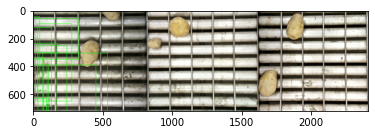

In [85]:
for box in out_dic['detection_boxes_raw'].numpy():
    box = np.round(box).astype(int)
    image = cv2.rectangle(img_test, (box[1], box[0]), (box[3], box[2]), (0, 255, 0), 2)
plt.imshow(image)

In [75]:
out_dic['detection_boxes_raw']

<tf.Tensor: shape=(14, 4), dtype=float32, numpy=
array([[ 569.6381   ,  -12.309673 , 2000.9056   ,   71.08107  ],
       [ 235.7011   ,  -48.71236  ,  736.3817   ,  172.0954   ],
       [ 306.70886  ,   70.40976  , 1186.6757   ,  534.747    ],
       [ 390.00134  ,  -61.42088  ,  852.4485   ,  100.75752  ],
       [ 301.15527  ,  -10.810772 , 1360.2876   ,  172.28587  ],
       [ 194.19849  ,  -35.794983 ,  648.91833  ,   16.748985 ],
       [  96.73428  ,   33.180542 ,  648.05853  ,  279.18225  ],
       [ 628.1976   ,  -51.087475 , 1705.3036   ,   97.04381  ],
       [  61.475418 ,   -8.486359 ,  350.88037  ,  328.71497  ],
       [ 342.61664  ,  -21.916079 ,  984.14905  ,   76.71408  ],
       [ 125.11333  ,   -3.1977768,  837.52014  ,  131.6663   ],
       [ 391.38443  ,  111.89377  , 1694.5187   ,  451.7339   ],
       [ 253.59749  ,   34.780533 ,  817.5105   ,  242.6664   ],
       [  47.46324  ,  -27.161243 ,  536.03723  ,   48.201397 ]],
      dtype=float32)>

In [90]:
out_dic['detection_boxes']

<tf.Tensor: shape=(14, 4), dtype=float32, numpy=
array([[1.        , 0.        , 1.        , 0.23867904],
       [1.        , 0.        , 1.        , 0.57316357],
       [1.        , 0.22983365, 1.        , 1.        ],
       [1.        , 0.        , 1.        , 0.33694544],
       [1.        , 0.        , 1.        , 0.5737943 ],
       [1.        , 0.        , 1.        , 0.05877148],
       [1.        , 0.10655808, 1.        , 0.9277558 ],
       [1.        , 0.        , 1.        , 0.32464838],
       [0.6719491 , 0.        , 1.        , 1.        ],
       [1.        , 0.        , 1.        , 0.2573314 ],
       [1.        , 0.        , 1.        , 0.4392924 ],
       [1.        , 0.3671979 , 1.        , 1.        ],
       [1.        , 0.11185607, 1.        , 0.8068424 ],
       [0.51625824, 0.        , 1.        , 0.16291854]], dtype=float32)>

In [43]:
for _ in range(20):
    tic = time.time()
    forward(img[None, ...])
    print("fps: ", 1/(time.time() - tic))

fps:  92.34690327836368
fps:  23.88501400879251
fps:  23.691011172490143
fps:  24.003662668253824
fps:  20.48060001757864
fps:  28.248656366599764
fps:  25.610942175001526
fps:  25.976873958739773
fps:  25.847845244624665
fps:  25.700392156862744
fps:  26.001996193593584
fps:  25.605157288760555
fps:  25.70858361732905
fps:  26.169258029898426
fps:  26.12410854982467
fps:  25.93527163898542
fps:  26.064690931462412
fps:  25.773353488429255
fps:  26.187557753302865
fps:  25.982828045048507


# Saved_model to frozen_graph

In [155]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

loaded = tf.saved_model.load('./saved_model')
infer = loaded.signatures['serving_default']
f = tf.function(infer).get_concrete_function(inputs=tf.TensorSpec(shape=[None, None, None, 3], dtype=tf.uint8))
f2 = convert_variables_to_constants_v2(f)
graph_def = f2.graph.as_graph_def()

for node in graph_def.node:
    print(node.op, node.name)

with tf.io.gfile.GFile('frozen_graph.pb', 'wb') as f:
    f.write(graph_def.SerializeToString())

Placeholder inputs
Const 528902
Const 528920
Const 528938
Const 528956
Const 528970
Const 528986
Const 528998
Const 528840
Const 528854
Const 528870
Const 528888
Const 528904
Const 528922
Const 528940
Const 528958
Const 528972
Const 528988
Const 529000
Const 529014
Const 529028
Const 528856
Const 528872
Const 528890
Const 528906
Const 528924
Const 528942
Const 528748
Const 528974
Const 528990
Const 529002
Const 529016
Const 529030
Const 528842
Const 528858
Const 528874
Const 528892
Const 528908
Const 528926
Const 528944
Const 528730
Const 528750
Const 528762
Const 529004
Const 529018
Const 529032
Const 528826
Const 528844
Const 528860
Const 528876
Const 528894
Const 528910
Const 528928
Const 528694
Const 528708
Const 528734
Const 528752
Const 529006
Const 529020
Const 529034
Const 528808
Const 528828
Const 528846
Const 528862
Const 528878
Const 528896
Const 528912
Const 528668
Const 528682
Const 528696
Const 528710
Const 528738
Const 528754
Const 529022
Const 529036
Const 528792
Const 

Identity Func/StatefulPartitionedCall/input/_260
Identity Func/StatefulPartitionedCall/StatefulPartitionedCall/input/_622
Identity StatefulPartitionedCall/StatefulPartitionedCall/model_25/conv5_block1_1_conv/Conv2D/ReadVariableOp
Conv2D StatefulPartitionedCall/StatefulPartitionedCall/model_25/conv5_block1_1_conv/Conv2D
Identity Func/StatefulPartitionedCall/input/_261
Identity Func/StatefulPartitionedCall/StatefulPartitionedCall/input/_623
Identity StatefulPartitionedCall/StatefulPartitionedCall/model_25/conv5_block1_1_conv/BiasAdd/ReadVariableOp
BiasAdd StatefulPartitionedCall/StatefulPartitionedCall/model_25/conv5_block1_1_conv/BiasAdd
Identity Func/StatefulPartitionedCall/input/_262
Identity Func/StatefulPartitionedCall/StatefulPartitionedCall/input/_624
Identity StatefulPartitionedCall/StatefulPartitionedCall/model_25/conv5_block1_1_bn/ReadVariableOp
Identity Func/StatefulPartitionedCall/input/_263
Identity Func/StatefulPartitionedCall/StatefulPartitionedCall/input/_625
Identity Sta

# Testing anchor generation code

In [4]:
import numpy as np
import tensorflow as tf

from YOLACT.data import anchor

test_bbox = tf.convert_to_tensor((np.array([[204.044, 253.8351, 487.8226, 427.06363],
                                            [0, 140.01741, 550, 290.21936],
                                            [40.005028, 117.37102, 255.7913, 205.13097],
                                            [263.31314, 67.0434, 514.04736, 124.48139],
                                            [0, 503.79834, 487.0279, 550]])), dtype=tf.float32)

test_labels = tf.convert_to_tensor((np.array([[1],
                                              [2],
                                              [3],
                                              [4],
                                              [5]])), dtype=tf.float32)

anchorobj = anchor.Anchor(img_size_h=550, img_size_w=550,
                          feature_map_size=[[69,69], [35,35], [18,18], [9,9], [5,5]],
                          aspect_ratio=[1, 0.5, 2],
                          scale=[24, 48, 96, 192, 384])

In [5]:
def make_anchors(img_size, conv_h, conv_w, scale, aspect_ratios):
    prior_data = []
    # Iteration order is important (it has to sync up with the convout)
    for j, i in product(range(conv_h), range(conv_w)):
        # + 0.5 because priors are in center
        x = (i + 0.5) / conv_w
        y = (j + 0.5) / conv_h

        for ar in aspect_ratios:
            ar = sqrt(ar)
            w = scale * ar / img_size
            h = scale / ar / img_size
            
            prior_data += [x, y, w, h]

    return prior_data

In [6]:
feature_map_size=[[69,69], [35,35], [18,18], [9,9], [5,5]]
aspect_ratios=[1, 0.5, 2]
scales=[24, 48, 96, 192, 384]
anchors = []

for i, shape in enumerate(feature_map_size):
    anchors += make_anchors(550, shape[0], shape[1], scales[i], aspect_ratios)
    
anchors = tf.reshape(tf.convert_to_tensor(anchors), [-1, 4])

In [7]:
def encode(map_loc, center_anchors, include_variances=False):
    # center_gt = tf.map_fn(lambda x: map_to_center_form(x), map_loc)
    h = map_loc[:, 2] - map_loc[:, 0]
    w = map_loc[:, 3] - map_loc[:, 1]
    center_gt = tf.cast(tf.stack([map_loc[:, 1] + (w / 2), map_loc[:, 0] + (h / 2), w, h], axis=-1), tf.float32)
    variances = [0.1, 0.2]

    # calculate offset
    if include_variances:
        g_hat_cx = (center_gt[:, 0] - center_anchors[:, 0]) / center_anchors[:, 2] / variances[0]
        g_hat_cy = (center_gt[:, 1] - center_anchors[:, 1]) / center_anchors[:, 3] / variances[0]
    else:
        g_hat_cx = (center_gt[:, 0] - center_anchors[:, 0]) / center_anchors[:, 2]
        g_hat_cy = (center_gt[:, 1] - center_anchors[:, 1]) / center_anchors[:, 3]
    tf.debugging.assert_non_negative(center_anchors[:, 2] / center_gt[:, 2])
    tf.debugging.assert_non_negative(center_anchors[:, 3] / center_gt[:, 3])
    if include_variances:
        g_hat_w = tf.math.log(center_gt[:, 2] / center_anchors[:, 2]) / variances[1]
        g_hat_h = tf.math.log(center_gt[:, 3] / center_anchors[:, 3]) / variances[1]
    else:
        g_hat_w = tf.math.log(center_gt[:, 2] / center_anchors[:, 2])
        g_hat_h = tf.math.log(center_gt[:, 3] / center_anchors[:, 3])
    offsets = tf.stack([g_hat_cx, g_hat_cy, g_hat_w, g_hat_h], axis=-1)
    return offsets

In [8]:
def area(boxlist, scope=None):
    # https://github.com/tensorflow/models/blob/831281cedfc8a4a0ad7c0c37173963fafb99da37/official/vision/detection/utils/object_detection/box_list_ops.py#L48
    """Computes area of boxes.
    Args:
    boxlist: BoxList holding N boxes
    scope: name scope.
    Returns:
    a tensor with shape [N] representing box areas.
    """
    y_min, x_min, y_max, x_max = tf.split(
        value=boxlist, num_or_size_splits=4, axis=1)
    return tf.squeeze((y_max - y_min) * (x_max - x_min), [1])

In [9]:
def intersection(boxlist1, boxlist2, scope=None):
    # https://github.com/tensorflow/models/blob/831281cedfc8a4a0ad7c0c37173963fafb99da37/official/vision/detection/utils/object_detection/box_list_ops.py#L209
    """Compute pairwise intersection areas between boxes.
    Args:
    boxlist1: BoxList holding N boxes
    boxlist2: BoxList holding M boxes
    scope: name scope.
    Returns:
    a tensor with shape [N, M] representing pairwise intersections
    """
    y_min1, x_min1, y_max1, x_max1 = tf.split(
        value=boxlist1, num_or_size_splits=4, axis=1)
    y_min2, x_min2, y_max2, x_max2 = tf.split(
        value=boxlist2, num_or_size_splits=4, axis=1)
    all_pairs_min_ymax = tf.minimum(y_max1, tf.transpose(y_max2))
    all_pairs_max_ymin = tf.maximum(y_min1, tf.transpose(y_min2))
    intersect_heights = tf.maximum(0.0, all_pairs_min_ymax - all_pairs_max_ymin)
    all_pairs_min_xmax = tf.minimum(x_max1, tf.transpose(x_max2))
    all_pairs_max_xmin = tf.maximum(x_min1, tf.transpose(x_min2))
    intersect_widths = tf.maximum(0.0, all_pairs_min_xmax - all_pairs_max_xmin)
    return intersect_heights * intersect_widths

In [10]:
def iou(boxlist1, boxlist2, scope=None):
    # https://github.com/tensorflow/models/blob/831281cedfc8a4a0ad7c0c37173963fafb99da37/official/vision/detection/utils/object_detection/box_list_ops.py#L259
    """Computes pairwise intersection-over-union between box collections.
    Args:
    boxlist1: BoxList holding N boxes
    boxlist2: BoxList holding M boxes
    scope: name scope.
    Returns:
    a tensor with shape [N, M] representing pairwise iou scores.
    """
    intersections = intersection(boxlist1, boxlist2)
    areas1 = area(boxlist1)
    areas2 = area(boxlist2)
    unions = (
        tf.expand_dims(areas1, 1) + tf.expand_dims(areas2, 0) - intersections)
    return tf.where(
        tf.equal(intersections, 0.0),
        tf.zeros_like(intersections), tf.truediv(intersections, unions))

In [13]:
def matching(pos_thresh, neg_thresh, gt_bbox, gt_labels, priors):
    pairwise_iou = iou(priors, gt_bbox) # # size: [num_objects, num_priors]; anchors along the row and ground_truth clong the columns

    each_prior_max = tf.reduce_max(pairwise_iou, axis=-1) # size [num_priors]; iou with ground truth with the anchors
    each_prior_index = tf.math.argmax(pairwise_iou, axis=-1) # size [num_priors]; id of groud truth having max iou with the anchors

    each_box_max = tf.reduce_max(pairwise_iou, axis=0)
    each_box_index = tf.math.argmax(pairwise_iou, axis=0)

    # For the max IoU prior for each gt box, set its IoU to 2. This ensures that it won't be filtered
    # in the threshold step even if the IoU is under the negative threshold. This is because that we want
    # at least one prior to match with each gt box or else we'd be wasting training data.

    indices = tf.expand_dims(each_box_index,axis=-1)

    updates = tf.cast(tf.tile(tf.constant([2]), each_box_index.shape), dtype=tf.float32)
    each_prior_max = tf.tensor_scatter_nd_update(each_prior_max, indices, updates)

    # Set the index of the pair (prior, gt) we set the overlap for above.
    updates = tf.cast(tf.range(0,each_box_index.shape),dtype=tf.int64)
    each_prior_index = tf.tensor_scatter_nd_update(each_prior_index, indices, updates)

    each_prior_box = tf.gather(gt_bbox, each_prior_index) # size: [num_priors, 4]
    conf = tf.squeeze(tf.gather(gt_labels, each_prior_index) + 1) # the class of the max IoU gt box for each prior, size: [num_priors]


    neutral_label_index = tf.where(each_prior_max < pos_thresh)
    background_label_index = tf.where(each_prior_max < neg_thresh)

    conf = tf.tensor_scatter_nd_update(conf, neutral_label_index, -1*tf.ones(tf.size(neutral_label_index)))
    conf = tf.tensor_scatter_nd_update(conf, background_label_index, tf.zeros(tf.size(background_label_index)))

    offsets = encode(each_prior_box, priors)

    return offsets, conf, each_prior_box, each_prior_index

In [14]:
offsets, conf, each_prior_box, each_prior_index = \
    matching(0.5, 0.5, test_bbox/550, test_labels, anchors)

In [15]:
each_prior_box

<tf.Tensor: shape=(19248, 4), dtype=float32, numpy=
array([[0.3709891 , 0.46151835, 0.8869502 , 0.7764793 ],
       [0.3709891 , 0.46151835, 0.8869502 , 0.7764793 ],
       [0.3709891 , 0.46151835, 0.8869502 , 0.7764793 ],
       ...,
       [0.3709891 , 0.46151835, 0.8869502 , 0.7764793 ],
       [0.3709891 , 0.46151835, 0.8869502 , 0.7764793 ],
       [0.3709891 , 0.46151835, 0.8869502 , 0.7764793 ]], dtype=float32)>

In [138]:
_idx = tf.where(conf > 0.5)

In [139]:
_test = _decode(offsets, anchorobj.anchors)

In [140]:
_out = tf.squeeze(tf.gather(_test, _idx)).numpy()*550

In [142]:
_out

array([[ 40.00502, 117.37102, 255.79132, 205.13097],
       [  0.     , 140.01741, 550.     , 290.21936],
       [263.31314,  67.0434 , 514.04736, 124.48139],
       [  0.     , 140.01741, 550.     , 290.21936],
       [204.04402, 253.8351 , 487.8226 , 427.06363],
       [  0.     , 503.79837, 487.0279 , 550.     ]], dtype=float32)

In [143]:
test_bbox

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[204.044   , 253.8351  , 487.8226  , 427.06363 ],
       [  0.      , 140.01741 , 550.      , 290.21936 ],
       [ 40.005028, 117.37102 , 255.7913  , 205.13097 ],
       [263.31314 ,  67.0434  , 514.04736 , 124.48139 ],
       [  0.      , 503.79834 , 487.0279  , 550.      ]], dtype=float32)>

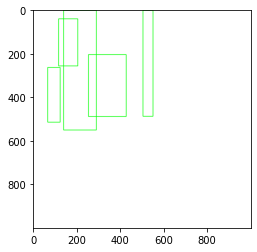

In [144]:
img_test = 255*np.ones((1000,1000,3), dtype=np.int8)

for box in _out:
    box = np.round(box).astype(int)
    image = cv2.rectangle(img_test, (box[1], box[0]), (box[3], box[2]), (0, 255, 0), 2)
plt.imshow(image)

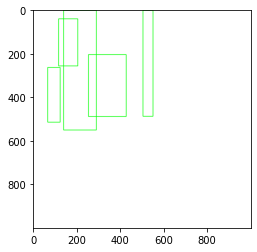

In [145]:
img_test = 255*np.ones((1000,1000,3), dtype=np.int8)

for box in test_bbox.numpy():
    box = np.round(box).astype(int)
    image = cv2.rectangle(img_test, (box[1], box[0]), (box[3], box[2]), (0, 255, 0), 2)
plt.imshow(image)

# Testing loss function

In [8]:
label=np.load('YOLACT/label.npy',allow_pickle=True).tolist()
pred=np.load('YOLACT/pred.npy',allow_pickle=True).tolist()

In [9]:
gt_offset = label['all_offsets'].numpy()[0]
pred_offset = pred['pred_offset'].numpy()[0]

In [12]:
_test = _decode(gt_offset, model.priors)

In [13]:
conf_gt = label['conf_gt'].numpy()[0]

In [14]:
pos_indices = tf.where(conf_gt > 0)

In [15]:
_out = tf.squeeze(tf.gather(_test, pos_indices)).numpy()*[360, 1205, 360, 1205]

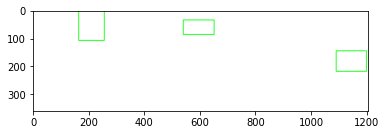

In [16]:
img_test = 255*np.ones((360,1205,3), dtype=np.int8)

for box in _out:
    box = np.round(box).astype(int)
    image = cv2.rectangle(img_test, (box[1], box[0]), (box[3], box[2]), (0, 255, 0), 2)
plt.imshow(image)

In [17]:
pred_offset = tf.gather_nd(pred_offset, pos_indices)
gt_offset = tf.gather_nd(gt_offset, pos_indices)

In [18]:
pred_offset

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[-1.1775408 ,  0.01081492,  4.00686   , -0.7663659 ],
       [ 0.00773525,  0.23271799,  1.3533934 , -0.7368684 ],
       [ 0.43033195, -0.12754941, -0.6475735 , -0.82432246]],
      dtype=float32)>

In [19]:
gt_offset

<tf.Tensor: shape=(3, 4), dtype=float32, numpy=
array([[ 3.5312916e+01,  9.9687490e+00,  1.2163953e+00,  1.4120027e+00],
       [ 2.0716145e+00,  6.5104193e-03, -8.3865488e-01, -1.0161686e+00],
       [ 8.8480431e-01, -8.2864076e-02, -6.1363631e-01, -4.9812350e-01]],
      dtype=float32)>

In [20]:
def _loss_location(pred_offset, gt_offset):
    # calculate the smoothL1(positive_pred, positive_gt) and return
    num_pos = tf.shape(gt_offset)[0]
    smoothl1loss = tf.keras.losses.Huber(delta=1., reduction=tf.losses.Reduction.NONE)
    loss_loc = tf.reduce_sum(smoothl1loss(gt_offset, pred_offset)) / tf.cast(num_pos, tf.float32)

    return loss_loc

In [21]:
_loss_location(pred_offset, gt_offset)

<tf.Tensor: shape=(), dtype=float32, numpy=4.4079823>

In [22]:
class_p = pred['pred_cls'].numpy()[0]

In [23]:
class_p.shape # one-hot encoded

(27429, 2)

In [24]:
conf_gt.shape

(27429,)

In [25]:
batch_conf = class_p

batch_conf_max = class_p.max()
mark = np.log(np.sum(np.exp(batch_conf - batch_conf_max), 1)) + batch_conf_max - batch_conf[:, 0]

In [26]:
# Hard Negative Mining
class_p.shape

(27429, 2)

In [27]:
mark = mark.reshape((class_p.shape[0], -1))

In [28]:
conf_gt.shape

(27429,)

In [41]:
np.sum(np.exp(batch_conf - batch_conf_max), 1)

array([0.02895284, 0.0038396 , 0.00401568, ..., 0.00241419, 0.00309208,
       0.00281499], dtype=float32)

In [43]:
batch_conf_max - batch_conf[:, 0]

array([7.4525847, 6.1767883, 6.8137903, ..., 6.5486817, 6.529446 ,
       6.4704933], dtype=float32)

In [46]:
batch_conf

array([[-1.1315335 ,  2.7587304 ],
       [ 0.14426276, -0.01996291],
       [-0.49273938,  0.4839047 ],
       ...,
       [-0.2276308 , -0.6046777 ],
       [-0.20839486, -0.0967323 ],
       [-0.1494422 , -0.35042235]], dtype=float32)

In [51]:
np.count_nonzero(conf_gt)

3

In [ ]:
batch_conf = tf.reshape(pred_cls, [-1, num_cls])
batch_conf_max = tf.math.reduce_max(pred_cls)

# Hard Negative Mining

# This will be used to determine unaveraged confidence loss across all examples in a batch.
# https://github.com/dbolya/yolact/blob/b97e82d809e5e69dc628930070a44442fd23617a/layers/modules/multibox_loss.py#L251
# https://github.com/dbolya/yolact/blob/b97e82d809e5e69dc628930070a44442fd23617a/layers/box_utils.py#L316
mark = tf.math.log(tf.math.reduce_sum(tf.math.exp(batch_conf-batch_conf_max), 1)) + batch_conf_max - batch_conf[:,0]

mark = tf.reshape(mark, (tf.shape(pred_cls)[0], -1))  # (n, 27429)
pos_indices = tf.where(conf_gt > 0 )
mark = tf.tensor_scatter_nd_update(mark, pos_indices, tf.zeros(tf.shape(pos_indices)[0])) # filter out pos boxes
num_pos = tf.math.count_nonzero(tf.greater(conf_gt,0), axis=1, keepdims=True)
num_neg = num_pos * self._neg_pos_ratio

neutrals_indices = tf.where(conf_gt < 0 )
mark = tf.tensor_scatter_nd_update(mark, neutrals_indices, tf.zeros(tf.shape(neutrals_indices)[0])) # filter out neutrals (conf_gt = -1)

idx = tf.argsort(mark, axis=1, direction='DESCENDING')
idx_rank = tf.argsort(idx, axis=1)

neg_indices = tf.where(tf.cast(idx_rank, dtype=tf.int64) < num_neg)
# Just in case there aren't enough negatives, don't start using positives as negatives
